## Final Project

As the final project for this course, I will be analysing customer product review data from the Amazon Kindle Store to answer the following research question: **Can sentiment analysis be used to predict the rating of an Amazon Kindle product based on textual reviews?**

The data used in this project was retrieved from Kaggle: https://www.kaggle.com/datasets/bharadwaj6/kindle-reviews/versions/3?resource=download.

### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import string
from wordcloud import WordCloud
from collections import Counter, OrderedDict
from nltk.classify import NaiveBayesClassifier
import random
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Import data

In [2]:
amazon_reviews = pd.read_json("../Data/kindle_reviews.json", lines=True)

### Conduct an initial exploration of the data

What is the shape of the data?

In [3]:
amazon_reviews.shape

(982619, 9)

The dataset has 9 columns and 982619 rows. What information is contained in the columns?

In [4]:
amazon_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982619 entries, 0 to 982618
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviewerID      982619 non-null  object
 1   asin            982619 non-null  object
 2   reviewerName    978820 non-null  object
 3   helpful         982619 non-null  object
 4   reviewText      982619 non-null  object
 5   overall         982619 non-null  int64 
 6   summary         982619 non-null  object
 7   unixReviewTime  982619 non-null  int64 
 8   reviewTime      982619 non-null  object
dtypes: int64(2), object(7)
memory usage: 67.5+ MB


How many missing values are present?

In [5]:
amazon_reviews.isna().sum()

reviewerID           0
asin                 0
reviewerName      3799
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64

How many unique products are present?

In [6]:
len(amazon_reviews.asin.unique())

61934

How many unique reviewers were there?

In [7]:
len(amazon_reviews.reviewerID.unique())

68223

### Select dataset features

Select the reviewText, summary and overall dataset columns for further analysis.

In [8]:
amazon_reviews_subset = amazon_reviews[["reviewText", "summary", "overall"]].copy()
len(amazon_reviews_subset)

982619

Remove duplicate reviews

In [9]:
amazon_reviews_subset = amazon_reviews_subset.drop_duplicates()
len(amazon_reviews_subset)

982483

### Divide reviews into groups corresponding to rating. 

Reviews with a rating of less than 3, equal to 3, and greater than 3 will be negative, neutral and positive, respectively. 

In [10]:
conditions = [
    amazon_reviews_subset["overall"] < 3, 
    amazon_reviews_subset["overall"] == 3, 
    amazon_reviews_subset["overall"] > 3
]

choices = ["negative", "neutral", "positive"]

amazon_reviews_subset["sentiment"] = np.select(conditions, choices)

amazon_reviews_subset.head(5)

,reviewText,summary,overall,sentiment
0,I enjoy vintage books and movies so I enjoyed ...,Nice vintage story,5,positive
1,This book is a reissue of an old one; the auth...,Different...,4,positive
2,This was a fairly interesting read. It had ol...,Oldie,4,positive
3,I'd never read any of the Amy Brewster mysteri...,I really liked it.,5,positive
4,"If you like period pieces - clothing, lingo, y...",Period Mystery,4,positive


Count the number of positive and negative reviews

In [11]:
len(amazon_reviews_subset[amazon_reviews_subset["sentiment"] == "positive"])

829147

In [12]:
len(amazon_reviews_subset[amazon_reviews_subset["sentiment"] == "negative"])

57148

Take a sample of 40000 reviews (20000 positive, 20000 negative) for testing

In [13]:
pos_sample = amazon_reviews_subset[amazon_reviews_subset["sentiment"] == "positive"].sample(n=20000,replace=True)
neg_sample = amazon_reviews_subset[amazon_reviews_subset["sentiment"] == "negative"].sample(n=20000,replace=True)

amazon_reviews_sample = pd.concat([pos_sample, neg_sample])
amazon_reviews_sample.head(5)

,reviewText,summary,overall,sentiment
719828,Danger and murder all twisted up with a beauti...,A Lie Forgiven,5,positive
846429,This is a fine collection of super simple proj...,Good for Beginners,4,positive
78354,"Four star. Very pleased with characters, look...",Good thriller,5,positive
156083,I had the wrong review for this book previousl...,A story of love and courage,4,positive
689530,This is a worthy addition to the Slaver Wars s...,Left me wanting more!,5,positive


### Convert reviews to lowercase

In [14]:
amazon_reviews_sample["reviewText"] = amazon_reviews_sample["reviewText"].astype(str).str.lower()
amazon_reviews_sample.head(5)

,reviewText,summary,overall,sentiment
719828,danger and murder all twisted up with a beauti...,A Lie Forgiven,5,positive
846429,this is a fine collection of super simple proj...,Good for Beginners,4,positive
78354,"four star. very pleased with characters, look...",Good thriller,5,positive
156083,i had the wrong review for this book previousl...,A story of love and courage,4,positive
689530,this is a worthy addition to the slaver wars s...,Left me wanting more!,5,positive


### Tokenize text

Split the text into individual words

In [15]:
amazon_reviews_sample["tokenized_review"] =  amazon_reviews_sample.reviewText.apply(nltk.word_tokenize)
amazon_reviews_sample.head(5)

,reviewText,summary,overall,sentiment,tokenized_review
719828,danger and murder all twisted up with a beauti...,A Lie Forgiven,5,positive,"[danger, and, murder, all, twisted, up, with, ..."
846429,this is a fine collection of super simple proj...,Good for Beginners,4,positive,"[this, is, a, fine, collection, of, super, sim..."
78354,"four star. very pleased with characters, look...",Good thriller,5,positive,"[four, star, ., very, pleased, with, character..."
156083,i had the wrong review for this book previousl...,A story of love and courage,4,positive,"[i, had, the, wrong, review, for, this, book, ..."
689530,this is a worthy addition to the slaver wars s...,Left me wanting more!,5,positive,"[this, is, a, worthy, addition, to, the, slave..."


### Remove stop words and punctuation

Remove punctuation and words that are not relevant

In [16]:
# Retrieve punctuation and common english stop words to be removed
removed_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)

# Drop negations from the removed_words list. Negations will be handled later in the analysis.
for word in ['not', 'n\'t', 'no', 'never']:
    if word in removed_words:
        removed_words.remove (word)

# Add some stop words

removed_words.extend(["\'s", "''", "``", "..."])

In [17]:
amazon_reviews_sample["without_stop_words"] = amazon_reviews_sample["tokenized_review"].apply(lambda x: [word for word in x if word not in removed_words])
amazon_reviews_sample.head(5)

,reviewText,summary,overall,sentiment,tokenized_review,without_stop_words
719828,danger and murder all twisted up with a beauti...,A Lie Forgiven,5,positive,"[danger, and, murder, all, twisted, up, with, ...","[danger, murder, twisted, beautiful, love, sto..."
846429,this is a fine collection of super simple proj...,Good for Beginners,4,positive,"[this, is, a, fine, collection, of, super, sim...","[fine, collection, super, simple, projects, as..."
78354,"four star. very pleased with characters, look...",Good thriller,5,positive,"[four, star, ., very, pleased, with, character...","[four, star, pleased, characters, look, forwar..."
156083,i had the wrong review for this book previousl...,A story of love and courage,4,positive,"[i, had, the, wrong, review, for, this, book, ...","[wrong, review, book, previously, deleted, one..."
689530,this is a worthy addition to the slaver wars s...,Left me wanting more!,5,positive,"[this, is, a, worthy, addition, to, the, slave...","[worthy, addition, slaver, wars, saga, resulte..."


### Handle negation

Words preceded by negations should not be interpreted as positive

In [18]:
def handle_negation(tokenized_list):

    negation_handled_list = []

    for word in tokenized_list:
        # next_word = tokenized_list[tokenized_list.index(word) + 1]
        if word in ['not', 'n\'t', 'no', 'never']:
            if tokenized_list.index(word) < len (tokenized_list) - 1:
                next_word = tokenized_list[tokenized_list.index(word) + 1]
                negation_handled_list.append("not_" + next_word)
        else:
            negation_handled_list.append(word)
        
    # negation_handled_list = ', '.join(negation_handled_list)    
    return negation_handled_list

In [19]:
amazon_reviews_sample["handled_negation"] =  amazon_reviews_sample.without_stop_words.apply(handle_negation)
amazon_reviews_sample.head(5)

,reviewText,summary,overall,sentiment,tokenized_review,without_stop_words,handled_negation
719828,danger and murder all twisted up with a beauti...,A Lie Forgiven,5,positive,"[danger, and, murder, all, twisted, up, with, ...","[danger, murder, twisted, beautiful, love, sto...","[danger, murder, twisted, beautiful, love, sto..."
846429,this is a fine collection of super simple proj...,Good for Beginners,4,positive,"[this, is, a, fine, collection, of, super, sim...","[fine, collection, super, simple, projects, as...","[fine, collection, super, simple, projects, as..."
78354,"four star. very pleased with characters, look...",Good thriller,5,positive,"[four, star, ., very, pleased, with, character...","[four, star, pleased, characters, look, forwar...","[four, star, pleased, characters, look, forwar..."
156083,i had the wrong review for this book previousl...,A story of love and courage,4,positive,"[i, had, the, wrong, review, for, this, book, ...","[wrong, review, book, previously, deleted, one...","[wrong, review, book, previously, deleted, one..."
689530,this is a worthy addition to the slaver wars s...,Left me wanting more!,5,positive,"[this, is, a, worthy, addition, to, the, slave...","[worthy, addition, slaver, wars, saga, resulte...","[worthy, addition, slaver, wars, saga, resulte..."


### Visualize the most common negative and positive sentiments

Extract and group all positive and negative words. Construct a WordCloud for the positive and negative groups.

In [20]:
positive_reviews =  amazon_reviews_sample[amazon_reviews_sample["sentiment"] == "positive"]["handled_negation"]
negative_reviews = amazon_reviews_sample[amazon_reviews_sample["sentiment"] == "negative"]["handled_negation"]

In [43]:
positive_words = WordCloud(background_color='white', width=800, height=400).generate(' '.join(positive_reviews.sum()))

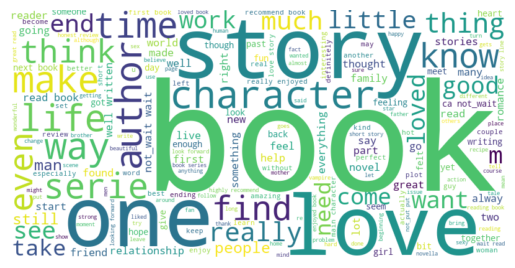

In [44]:
plt.imshow(positive_words, interpolation="bilinear")
plt.axis("off")

# Save the figure
plt.savefig("../Results/Figures/Positive_wordcloud.png", dpi=1200)

plt.show()

In [45]:
negative_words = WordCloud(background_color='white', width=800, height=400).generate(' '.join(negative_reviews.sum()))

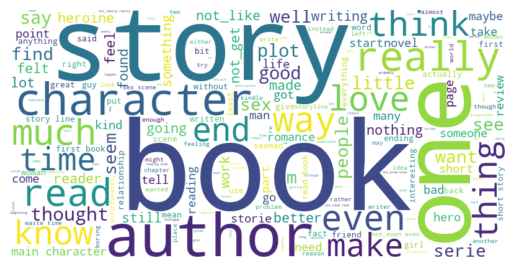

In [46]:
plt.imshow(negative_words, interpolation="bilinear")
plt.axis("off")

# Save the figure
plt.savefig("../Results/Figures/Negative_wordcloud.png", dpi=1200)

plt.show()

### Get the counts and frequencies of the positive and negative sentiments

Create lists with all positive and negative words

How many positive words were used?

In [25]:
positive_words = []
for list in positive_reviews:
    positive_words.extend(list)

len (positive_words)

1130091

Many words (955745) were used in the positive reviews. How many of these words are unique?

In [26]:
len (set(positive_words))

62694

Only 56349 of the 955745 words were unique.

How many negative words were used?

In [27]:
negative_words = []
for list in negative_reviews:
    negative_words.extend(list)

len (negative_words)

1066873

Much less words (63643) were used in the negative reviews in comparison to the positive reviews. How many of these words are unique?

In [28]:
len (set(negative_words))

52873

Only 10628 of the 63643 words were unique.

Count the frequencies of the positive and negative words

In [29]:
pos_word_counter = Counter(positive_words)
pos_word_counter

Counter({'danger': 242,
         'murder': 279,
         'twisted': 102,
         'beautiful': 851,
         'love': 10149,
         'story': 14568,
         'keep': 1792,
         'edge': 344,
         'seat.agent': 1,
         'jonah': 24,
         'white': 175,
         'lost': 617,
         'sister': 539,
         'many': 2266,
         'say': 2188,
         'suicide': 36,
         '8217': 5009,
         'believe': 734,
         'not_little': 5,
         'little': 3010,
         'went': 587,
         'search': 137,
         'truth': 255,
         'not_matter': 226,
         'matter': 378,
         'got': 1743,
         'hurt': 280,
         'ran': 84,
         'trouble': 284,
         'capital': 12,
         't.': 39,
         'could': 4044,
         'find': 2723,
         'killer': 177,
         'seek': 68,
         'revenge': 148,
         'without': 1113,
         'placing': 12,
         'even': 3319,
         'innocent': 124,
         'victims': 33,
         'path.read': 1,
   

In [30]:
neg_word_counter = Counter(negative_words)
neg_word_counter

Counter({'waste': 1240,
         'time': 4986,
         'money': 1655,
         'weird': 332,
         'immature': 247,
         'dialogue': 743,
         'limited': 66,
         'background': 257,
         'main': 1801,
         'characters': 5731,
         'world': 878,
         'better': 2568,
         'dragon': 63,
         'stories': 1617,
         'spend': 297,
         'okay': 822,
         'get': 6121,
         'fact': 943,
         'authors': 865,
         'put': 1145,
         'lot': 1869,
         'work': 1578,
         'book': 25482,
         'nice': 563,
         'make': 2750,
         'free': 2329,
         'readers': 679,
         'means': 259,
         'generating': 5,
         'revenue': 4,
         'web': 52,
         'traffic': 22,
         '....': 1063,
         'books': 4624,
         'begin': 236,
         'pitch': 10,
         'suggests': 77,
         'e': 57,
         'go': 1849,
         'certain': 227,
         'website': 74,
         'upload': 10,
         'i

In [31]:
Counter(negative_words)
neg_word_counter

Counter({'waste': 1240,
         'time': 4986,
         'money': 1655,
         'weird': 332,
         'immature': 247,
         'dialogue': 743,
         'limited': 66,
         'background': 257,
         'main': 1801,
         'characters': 5731,
         'world': 878,
         'better': 2568,
         'dragon': 63,
         'stories': 1617,
         'spend': 297,
         'okay': 822,
         'get': 6121,
         'fact': 943,
         'authors': 865,
         'put': 1145,
         'lot': 1869,
         'work': 1578,
         'book': 25482,
         'nice': 563,
         'make': 2750,
         'free': 2329,
         'readers': 679,
         'means': 259,
         'generating': 5,
         'revenue': 4,
         'web': 52,
         'traffic': 22,
         '....': 1063,
         'books': 4624,
         'begin': 236,
         'pitch': 10,
         'suggests': 77,
         'e': 57,
         'go': 1849,
         'certain': 227,
         'website': 74,
         'upload': 10,
         'i

### Plot the frequencies

Sort the numerical data

In [32]:
pos_sorted_word_counts = sorted(pos_word_counter.values(), reverse=True)
neg_sorted_word_counts = sorted(neg_word_counter.values(), reverse=True)

Plot the positive word count frequencies

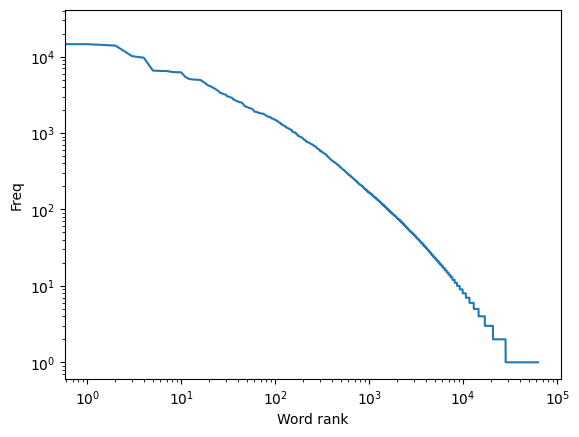

In [33]:
plt.loglog(pos_sorted_word_counts)
plt.ylabel("Freq")
plt.xlabel("Word rank")

# Save the figure
plt.savefig("../Results/Figures/Positive_frequency.png", dpi=1200)

plt.show()

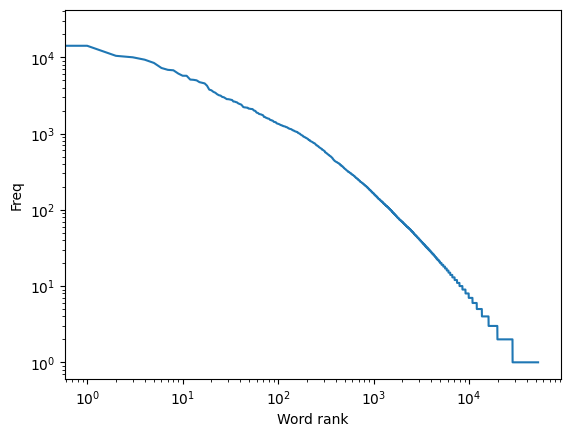

In [34]:
plt.loglog(neg_sorted_word_counts)
plt.ylabel("Freq")
plt.xlabel("Word rank")

# Save the figure
plt.savefig("../Results/Figures/Negative_frequency.png", dpi=1200)

plt.show()

### Train a classifier for sentiment analysis

Create a bag of words to house the positive and negative words contained in each review. 

In [35]:
# Create a function to build a bag of words for each review

def build_bag_of_words(review):
    return {word:1 for word in review}

In [36]:
# Build a list of positive/negative words contained in each review. Associate the term 'pos' or 'neg' with the positive and negative words, respectively.

negative_features = [
    (build_bag_of_words(value), "neg") for value in negative_reviews.values
]

positive_features = [
    (build_bag_of_words(value), "pos") for value in positive_reviews.values
]

Classify the data using a Naive Bayes supervised machine learning classifier. Train the data on 80% of the data. Use the remaining 20% for testing purposes.

Determine how many records make up 80% of the data.

In [37]:
pos_split = len (positive_features) * 0.8
round(pos_split)

16000

In [38]:
neg_split = len (negative_features) * 0.8
round(neg_split)

16000

Train the classifier. Check the accuracy of the training set. We expect a high percentage as the classifier algorithm already saw this data. Check the accuracy using the test data. The classifier algorithm has not seen this data. 

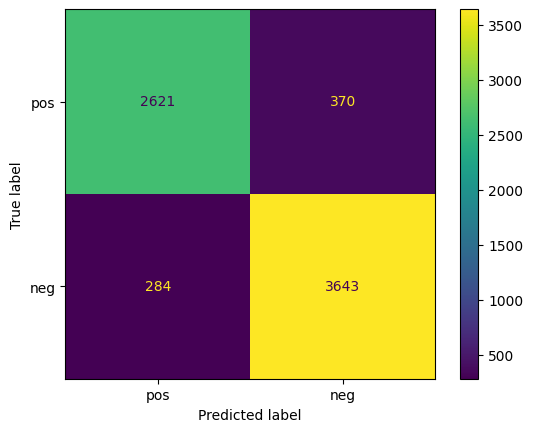

Most Informative Features
               not_worth = 1                 neg : pos    =    113.4 : 1.0
          not_disappoint = 1                 pos : neg    =    103.0 : 1.0
              not_finish = 1                 neg : pos    =     55.5 : 1.0
              disappoint = 1                 pos : neg    =     46.6 : 1.0
               heartache = 1                 pos : neg    =     39.0 : 1.0
                     4.5 = 1                 pos : neg    =     38.2 : 1.0
              amateurish = 1                 neg : pos    =     35.7 : 1.0
                  drivel = 1                 neg : pos    =     30.3 : 1.0
               redeeming = 1                 neg : pos    =     30.3 : 1.0
             beautifully = 1                 pos : neg    =     30.1 : 1.0


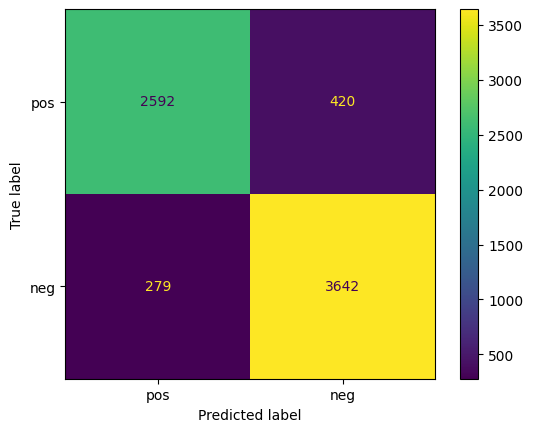

Most Informative Features
               not_worth = 1                 neg : pos    =    185.0 : 1.0
                  refund = 1                 neg : pos    =     85.0 : 1.0
          not_disappoint = 1                 pos : neg    =     57.8 : 1.0
              not_finish = 1                 neg : pos    =     54.1 : 1.0
              amateurish = 1                 neg : pos    =     38.3 : 1.0
                deleting = 1                 neg : pos    =     38.3 : 1.0
                     4.5 = 1                 pos : neg    =     37.8 : 1.0
                   waste = 1                 neg : pos    =     32.9 : 1.0
                  poorly = 1                 neg : pos    =     31.1 : 1.0
              pleasantly = 1                 pos : neg    =     30.6 : 1.0


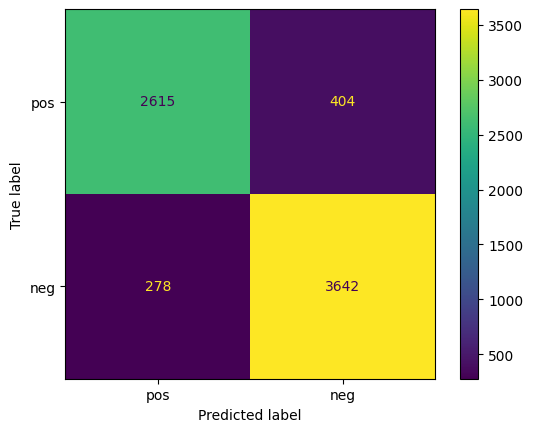

Most Informative Features
               not_worth = 1                 neg : pos    =    191.0 : 1.0
          not_disappoint = 1                 pos : neg    =    105.7 : 1.0
                  refund = 1                 neg : pos    =     86.3 : 1.0
              not_finish = 1                 neg : pos    =     52.6 : 1.0
                not_flow = 1                 neg : pos    =     39.0 : 1.0
                deleting = 1                 neg : pos    =     38.3 : 1.0
              amateurish = 1                 neg : pos    =     37.7 : 1.0
              pleasantly = 1                 pos : neg    =     35.0 : 1.0
                  poorly = 1                 neg : pos    =     32.6 : 1.0
                   waste = 1                 neg : pos    =     30.5 : 1.0


In [40]:
accur_report = pd.DataFrame()
clas_report = pd.DataFrame()

measurement_accur_report = pd.DataFrame()

# Create a random sample of positive and negative training data

pos_train = random.sample(positive_features, round(pos_split))
neg_train = random.sample(negative_features, round(neg_split))

# Get the remaining test data

pos_test = [x for x in positive_features if x not in pos_train]
neg_test = [x for x in negative_features if x not in neg_train]

# Train the classifier

classifier = NaiveBayesClassifier.train(pos_train + neg_train)

# Test the accuracy

train_accuracy = nltk.classify.util.accuracy(classifier, pos_train + neg_train)*100
test_accuracy = nltk.classify.util.accuracy(classifier, pos_test + neg_test)*100

# Create a classification report

observed_result = []
actual_result = []
pos_and_neg_set = pos_test + neg_test

for i in range(len(pos_and_neg_set)):
    observed_result.append(classifier.classify(pos_and_neg_set[i][0]))
    actual_result.append(pos_and_neg_set[i][1])

measurement_clas_report = pd.DataFrame(classification_report(actual_result, observed_result, output_dict=True)).transpose()[:2]

measurement_clas_report["measurement"] = measurement

# Create a confusion matrix for each measurement

measurement_conf_matrix = confusion_matrix(actual_result, observed_result)
measurement_conf_matrix_display = ConfusionMatrixDisplay(measurement_conf_matrix, display_labels=['pos','neg'])
measurement_conf_matrix_display.plot()

# Save and show the figure
plt.savefig("../Results/Figures/Confusion_matrix_" + str(measurement) + ".png", dpi=1200)

plt.show()

# Show the most informative features for each measurement

classifier.show_most_informative_features()

# Save the results

measurement_accur_report["train_accuracy"] = [train_accuracy]
measurement_accur_report["test_accuracy"] = [test_accuracy]

accur_report = pd.concat([accur_report, measurement_accur_report])

clas_report = pd.concat([clas_report, measurement_clas_report])

accur_report = accur_report.reset_index(drop=True)

In [41]:
accur_report

,train_accuracy,test_accuracy
0,95.025000,90.546401
1,95.031250,89.917785
2,95.015625,90.171494


In [42]:
clas_report

,precision,recall,f1-score,support,measurement
neg,0.902238,0.876296,0.889077,2991.0,0
pos,0.907800,0.927680,0.917632,3927.0,0
neg,0.902821,0.860558,0.881183,3012.0,1
pos,0.896603,0.928845,0.912439,3921.0,1
neg,0.903906,0.866181,0.884641,3019.0,2
pos,0.900148,0.929082,0.914386,3920.0,2
